In [1]:
import torch
import torch_geometric as tg
from torch_geometric.loader import DataLoader
from torch_geometric import datasets, nn
import pytorch_lightning as L
from torcheval import metrics
import matplotlib.pyplot as plt
import scienceplots
import os
from pathlib import Path

In [2]:
train_data = datasets.UPFD("./datasets", "gossipcop", feature="content", split="test")
test_data = datasets.UPFD("./datasets", "gossipcop", feature="content", split="train")
val_data = datasets.UPFD("./datasets", "gossipcop", feature="content", split="val")

In [3]:
train_loader = DataLoader(
    train_data,
    batch_size=128,
    shuffle=True,
    drop_last=False,
    num_workers=2,
    persistent_workers=True
)
val_loader = DataLoader(
    val_data,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    persistent_workers=True
)
test_loader = DataLoader(
    test_data,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    persistent_workers=True
)

In [4]:
class FakeNewsGNN(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        dropout: int,
        num_layers: int,
        num_heads: int,
    ) -> None:
        super(FakeNewsGNN, self).__init__()
        self.gat = torch.nn.ModuleList()
        for i in range(num_layers):
            self.gat.append(
                nn.GATConv(
                    in_channels if i == 0 else hidden_channels,
                    hidden_channels,
                    heads=num_heads,
                )
            )

        self.dropout = torch.nn.Dropout(dropout)
        self.act = torch.nn.ReLU()
        self.lin_news = torch.nn.Linear(in_channels, hidden_channels)
        self.lin0 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(2 * hidden_channels, out_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data: tg.data.Batch):
        h = data.x
        for layer in self.gat:
            h = layer(h, data.edge_index)
            h = self.act(h)

        # Pooling
        h = nn.global_max_pool(h, data.batch)
        # Readout
        h = self.lin0(h)
        h = self.act(h)

        root = (data.batch[1:] - data.batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        news = data.x[root]
        news = self.act(self.lin_news(news))

        out = torch.cat([h, news], dim=-1)
        out = self.lin1(out)
        return self.sigmoid(out)

In [5]:
from typing import Any


class FakeNewsTrainer(L.LightningModule):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_layers: int,
        dropout: float,
        num_heads: int,
        lr: float,
    ) -> None:
        super().__init__()
        self.model = FakeNewsGNN(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            num_layers=num_layers,
            dropout=dropout,
            num_heads=num_heads,
        )

        self.lr = lr
        self.criterion = torch.nn.BCELoss()
        self.history = {
            "epochs": [],
            "loss": [],
            "val_loss": [],
            "acc": [],
            "val_acc": [],
        }

        self.training_step_outputs = {
            "loss": [],
            "val_loss": [],
            "acc": [],
            "val_acc": [],
        }

        self.save_hyperparameters()

    def forward(self, data: tg.data.Batch):
        return self.model(data)

    def _shared_eval_step(self, data: tg.data.Batch):
        acc = metrics.BinaryAccuracy()
        pred = self.model(data)
        loss = self.criterion(pred.view(-1,), data.y.float())
        accuracy = acc.update(pred.view(-1,), data.y.float())
        return loss, accuracy.compute()

    def training_step(self, data: tg.data.Batch):
        loss, accuracy = self._shared_eval_step(data)
        self.log("train_loss", loss.item(), prog_bar=True, batch_size=data.batch_size)
        self.log("train_acc", accuracy, prog_bar=True, batch_size=data.batch_size)
        self.training_step_outputs["loss"].append(loss.item())
        self.training_step_outputs["acc"].append(accuracy)
        return loss * data.num_graphs

    def validation_step(self, data: tg.data.Batch):
        loss, accuracy = self._shared_eval_step(data)
        self.log("val_loss", loss.item(), prog_bar=True, batch_size=data.batch_size)
        self.log("val_acc", accuracy, prog_bar=True, batch_size=data.batch_size)
        self.training_step_outputs["val_loss"].append(loss.item())
        self.training_step_outputs["val_acc"].append(accuracy)
        return loss * data.num_graphs

    def test_step(self, data: tg.data.Batch):
        loss, accuracy = self._shared_eval_step(data)
        self.log("test_loss", loss.item(), prog_bar=True, batch_size=data.batch_size)
        self.log("test_acc", accuracy, prog_bar=True, batch_size=data.batch_size)
        return loss * data.num_graphs

    def on_train_epoch_end(self) -> None:
        self.history["epochs"].append(self.current_epoch)
        for key, item in self.training_step_outputs.items():
            self.history[key].append(sum(item) / len(item))

        self.training_step_outputs = {
            "loss": [],
            "val_loss": [],
            "acc": [],
            "val_acc": [],
        }

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [6]:
fake_news_model = FakeNewsTrainer(
    in_channels=train_data.num_features,
    hidden_channels=128,
    out_channels=1,
    num_layers=3,
    dropout=0.2,
    num_heads=1,
    lr=1e-3,
)

In [7]:
fake_news_model

FakeNewsTrainer(
  (model): FakeNewsGNN(
    (gat): ModuleList(
      (0): GATConv(310, 128, heads=1)
      (1-2): 2 x GATConv(128, 128, heads=1)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (act): ReLU()
    (lin_news): Linear(in_features=310, out_features=128, bias=True)
    (lin0): Linear(in_features=128, out_features=128, bias=True)
    (lin1): Linear(in_features=256, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (criterion): BCELoss()
)

In [8]:
timer = L.callbacks.Timer()
early_stopping = L.callbacks.EarlyStopping(patience=10, monitor="val_loss", mode="min")
checkpoint = L.callbacks.ModelCheckpoint(dirpath="./lightning_logs/FakeNews/")
callbacks = [timer, early_stopping]

In [9]:
trainer = L.Trainer(
    accelerator="gpu",
    num_sanity_val_steps=0,
    val_check_interval=1,
    callbacks=callbacks,
    max_epochs=300,
    default_root_dir="./lightning_logs/FakeNews"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [10]:
trainer.fit(fake_news_model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | model     | FakeNewsGNN | 130 K 
1 | criterion | BCELoss     | 0     
------------------------------------------
130 K     Trainable params
0         Non-trainable params
130 K     Total params
0.521     Total estimated model params size (MB)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   3%|▎         | 1/30 [00:06<03:06,  0.16it/s, v_num=11, train_loss=0.691, train_acc=0.523]

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 40: 100%|██████████| 30/30 [00:09<00:00,  3.29it/s, v_num=11, train_loss=0.0943, train_acc=0.982, val_loss=0.099, val_acc=0.971]  


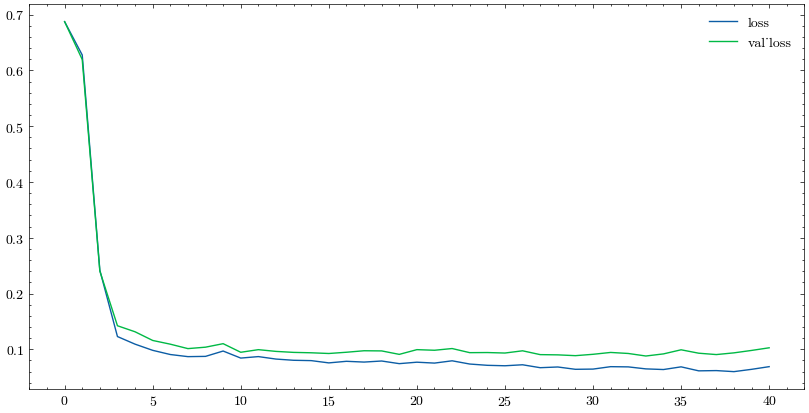

In [11]:
plt.style.use(["science", "no-latex"])
plt.figure(figsize=(10, 5))

plt.plot(range(fake_news_model.current_epoch), fake_news_model.history["loss"])
plt.plot(range(fake_news_model.current_epoch), fake_news_model.history["val_loss"])
plt.legend(["loss", "val_loss"])

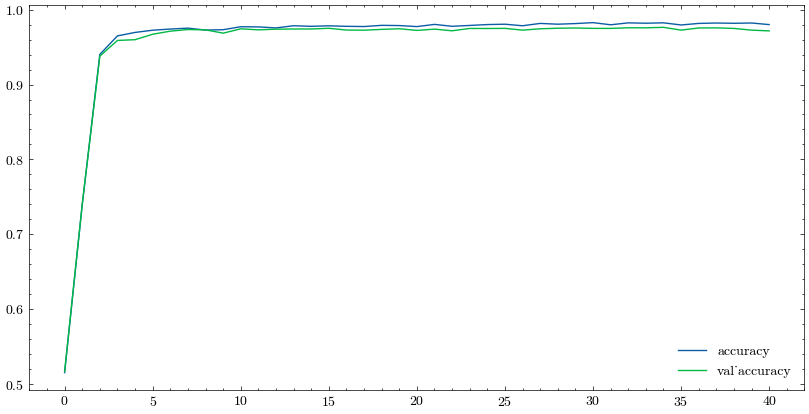

In [12]:
plt.style.use(["science", "no-latex"])
plt.figure(figsize=(10, 5))

plt.plot(range(fake_news_model.current_epoch), fake_news_model.history["acc"])
plt.plot(range(fake_news_model.current_epoch), fake_news_model.history["val_acc"])
plt.legend(["accuracy", "val_accuracy"])

In [13]:
paths = sorted(Path("./lightning_logs/FakeNews/lightning_logs").iterdir(), key=os.path.getmtime, reverse=True)

ckpt_path = os.path.join(paths[0], "checkpoints")
ckpt_file = os.listdir(ckpt_path)[0]
ckpt_full_path = os.path.join(ckpt_path, ckpt_file)

In [14]:
model = FakeNewsTrainer.load_from_checkpoint(ckpt_full_path)

In [15]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 26.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9752747416496277
        test_loss           0.0896403044462204
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0896403044462204, 'test_acc': 0.9752747416496277}]

In [16]:
print(f"Train time: {timer.time_elapsed('train'):.3f}s")
print(f"Validate time: {timer.time_elapsed('validate'):.3f}s")
print(f"Test time: {timer.time_elapsed('test'):.3f}s")

Train time: 327.468s
Validate time: 0.187s
Test time: 6.406s
